# Step 1: Import Libraries

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer

# Step 2: Load and Preprocess Data

In [2]:
# Load datasets
attributes_df = pd.read_csv("data/Attributes_DataFrame.csv")
daily_df = pd.read_csv("data/Daily_DataFrame.csv")

In [3]:
# Display first few rows of the datasets to understand their structure
attributes_df.head()

,Title,Domestic,International,Budget,Distributor,MPAA-Rating,Runtime,Genres
0,Jurassic World (2015),652270625,1018130012,150000000.0,Universal Pictures,PG-13,124,Action;Adventure;Sci-Fi
1,Star Wars: Episode VII - The Force Awakens (2015),936662225,1131561399,245000000.0,Walt Disney Studios Motion Pictures,PG-13,138,Action;Adventure;Sci-Fi
2,Avengers: Age of Ultron (2015),459005868,943800000,250000000.0,Walt Disney Studios Motion Pictures,PG-13,141,Action;Adventure;Sci-Fi
3,Inside Out (2015),356461711,501149463,175000000.0,Walt Disney Studios Motion Pictures,PG,95,Adventure;Animation;Comedy;Drama;Family;Fantasy
4,Furious 7 (2015),353007020,1162040651,190000000.0,Universal Pictures,PG-13,137,Action;Adventure;Thriller


In [4]:
# Display first few rows of the datasets to understand their structure
daily_df.head()

,Movie_Title,Date,Daily,Theaters,Rank
0,Jurassic World (2015),12/6/2015,81953950,4274.0,1
1,Jurassic World (2015),13/6/2015,69644830,4274.0,1
2,Jurassic World (2015),14/6/2015,57207490,4274.0,1
3,Jurassic World (2015),15/6/2015,25344820,4274.0,1
4,Jurassic World (2015),16/6/2015,24342515,4274.0,1


# Step 3: Merge Datasets and Handle Missing Values

In [5]:
# Merge datasets on movie title
merged_df = daily_df.merge(attributes_df, left_on="Movie_Title", right_on="Title", how="left")
merged_df.drop(columns=["Title"], inplace=True)

# Handle missing data: Fill numerical columns with mean and categorical with the mode
numerical_cols = merged_df.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = merged_df.select_dtypes(include=["object"]).columns

# Impute missing values
from sklearn.impute import SimpleImputer

# Impute numerical columns with the mean
imputer_num = SimpleImputer(strategy='mean')
merged_df[numerical_cols] = imputer_num.fit_transform(merged_df[numerical_cols])

# Impute categorical columns with the most frequent value
imputer_cat = SimpleImputer(strategy='most_frequent')
merged_df[categorical_cols] = imputer_cat.fit_transform(merged_df[categorical_cols])

# Display the cleaned dataframe
merged_df.head()


,Movie_Title,Date,Daily,Theaters,Rank,Domestic,International,Budget,Distributor,MPAA-Rating,Runtime,Genres
0,Jurassic World (2015),12/6/2015,81953950.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,124.0,Action;Adventure;Sci-Fi
1,Jurassic World (2015),13/6/2015,69644830.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,124.0,Action;Adventure;Sci-Fi
2,Jurassic World (2015),14/6/2015,57207490.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,124.0,Action;Adventure;Sci-Fi
3,Jurassic World (2015),15/6/2015,25344820.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,124.0,Action;Adventure;Sci-Fi
4,Jurassic World (2015),16/6/2015,24342515.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,124.0,Action;Adventure;Sci-Fi


# Step 4: Feature Engineering

In [6]:
# Convert Date to datetime object and extract useful features
merged_df["Date"] = pd.to_datetime(merged_df["Date"], dayfirst=True)
merged_df["Year"] = merged_df["Date"].dt.year
merged_df["Month"] = merged_df["Date"].dt.month
merged_df["Day"] = merged_df["Date"].dt.day
merged_df["DayOfWeek"] = merged_df["Date"].dt.weekday  # 0=Monday, 6=Sunday

# One-Hot Encode categorical variables
categorical_cols = ["Distributor", "MPAA-Rating"]
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(merged_df[categorical_cols]))
encoded_cats.columns = encoder.get_feature_names_out(categorical_cols)
encoded_cats.index = merged_df.index

# Concatenate encoded categorical features
merged_df = pd.concat([merged_df, encoded_cats], axis=1)

# Process Genres (multi-label encoding)
merged_df["Genres"] = merged_df["Genres"].apply(lambda x: x.split(";") if isinstance(x, str) else [])
mlb = MultiLabelBinarizer()
genres_onehot = mlb.fit_transform(merged_df["Genres"])
genres_df = pd.DataFrame(genres_onehot, columns=mlb.classes_, index=merged_df.index)

# Concatenate genre features
merged_df = pd.concat([merged_df, genres_df], axis=1)

# Display final dataframe for analysis
merged_df.head()

,Movie_Title,Date,Daily,Theaters,Rank,Domestic,International,Budget,Distributor,MPAA-Rating,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Jurassic World (2015),2015-06-12,81953950.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,...,0,0,0,0,1,0,0,0,0,0
1,Jurassic World (2015),2015-06-13,69644830.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,...,0,0,0,0,1,0,0,0,0,0
2,Jurassic World (2015),2015-06-14,57207490.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,...,0,0,0,0,1,0,0,0,0,0
3,Jurassic World (2015),2015-06-15,25344820.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,...,0,0,0,0,1,0,0,0,0,0
4,Jurassic World (2015),2015-06-16,24342515.0,4274.0,1.0,652270625.0,1.018130e+09,150000000.0,Universal Pictures,PG-13,...,0,0,0,0,1,0,0,0,0,0


# Step 5: Visualizing Data relation between features

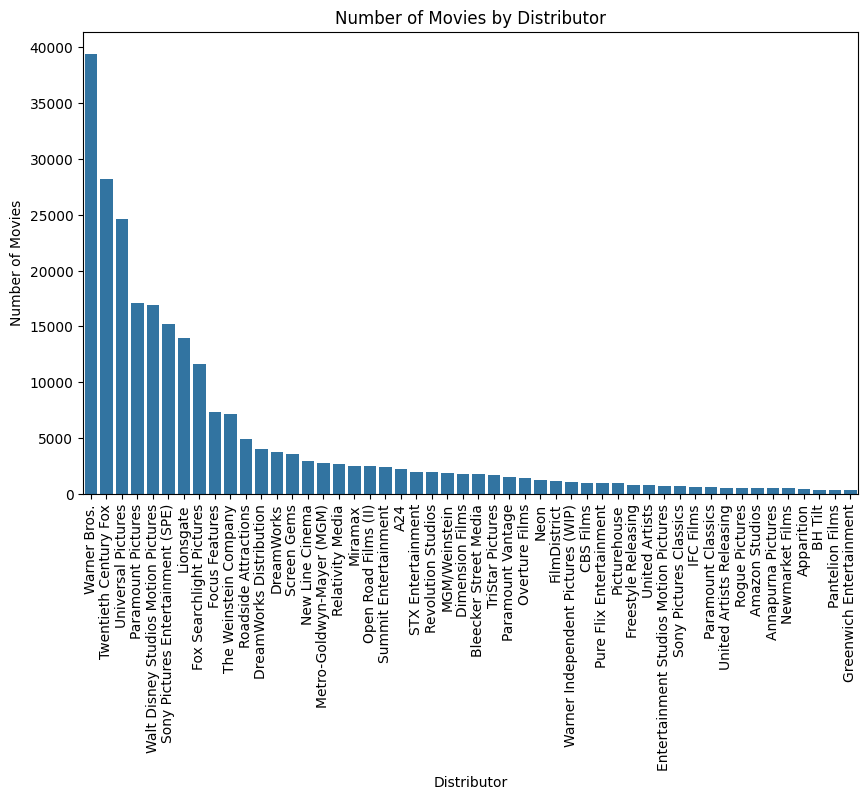

In [7]:
# 1. Distribution of the number of movies from each distributor
plt.figure(figsize=(10, 6))
distributor_counts = merged_df['Distributor'].value_counts()

# Limit to the top 50 distributors
top_distributors = distributor_counts.head(50)

sns.barplot(x=top_distributors.index, y=top_distributors.values)
plt.xticks(rotation=90)
plt.title('Number of Movies by Distributor')
plt.xlabel('Distributor')
plt.ylabel('Number of Movies')
plt.show()


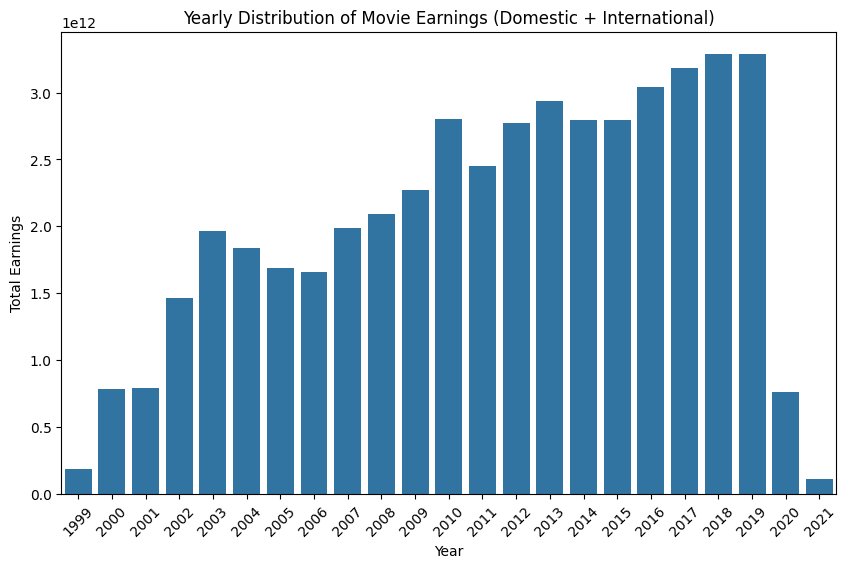

In [8]:
# 2. Yearly distribution of how well movies did (Domestic + International Earnings)
merged_df['Year'] = pd.to_datetime(merged_df['Date']).dt.year
merged_df['Total_Earnings'] = merged_df['Domestic'] + merged_df['International']

# Group by year and calculate the total earnings per year
yearly_earnings = merged_df.groupby('Year')['Total_Earnings'].sum()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_earnings.index, y=yearly_earnings.values)
plt.title('Yearly Distribution of Movie Earnings (Domestic + International)')
plt.xlabel('Year')
plt.ylabel('Total Earnings')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.show()


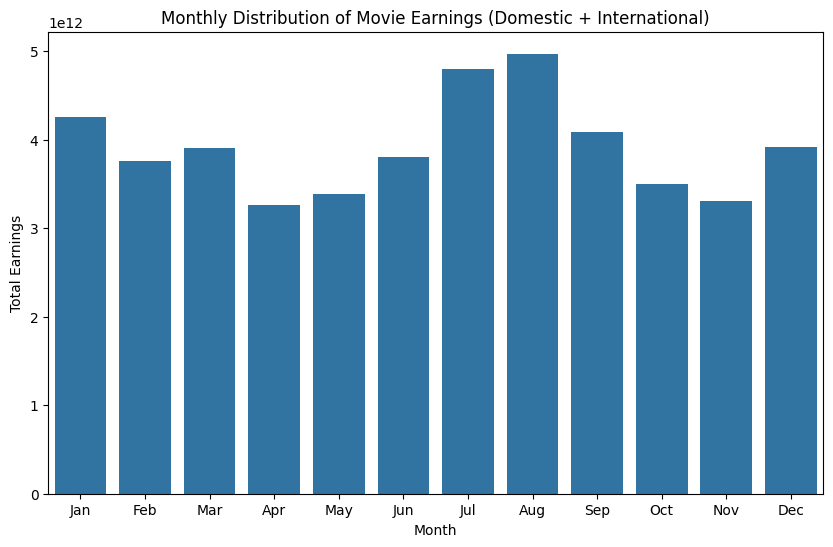

In [9]:
# 3. Monthly distribution of how well movies did (Domestic + International Earnings)
merged_df['Month'] = pd.to_datetime(merged_df['Date']).dt.month

plt.figure(figsize=(10, 6))
monthly_earnings = merged_df.groupby('Month')['Total_Earnings'].sum().reset_index()
sns.barplot(x='Month', y='Total_Earnings', data=monthly_earnings)
plt.title('Monthly Distribution of Movie Earnings (Domestic + International)')
plt.xlabel('Month')
plt.ylabel('Total Earnings')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

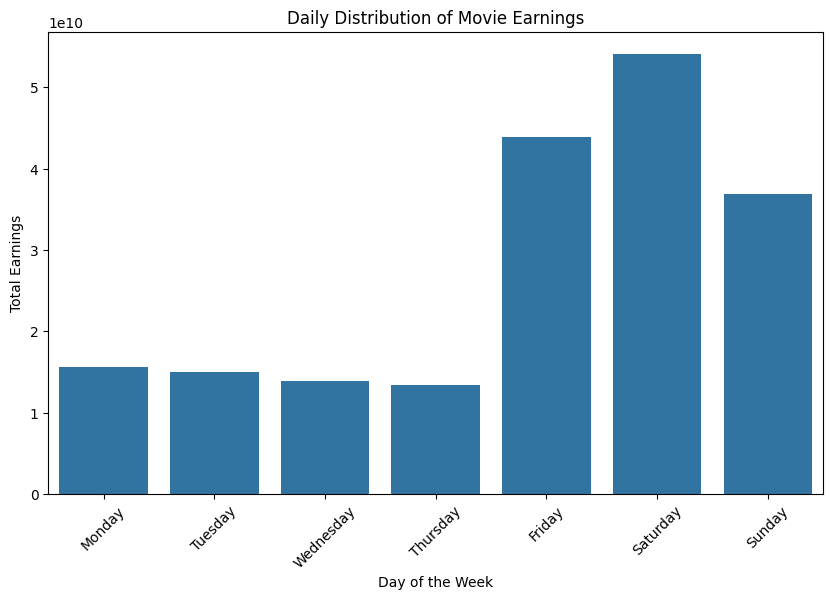

In [10]:
# 4. Daily distribution of how well movies did (Domestic + International Earnings)
# We will take the daily earnings (already provided in 'Daily' column) and sum them up
plt.figure(figsize=(10, 6))

# Add a new column for the day of the week
daily_earnings = daily_df.groupby('Date')['Daily'].sum().reset_index()
daily_earnings['Date'] = pd.to_datetime(daily_earnings['Date'], dayfirst=True)
daily_earnings['DayOfWeek'] = daily_earnings['Date'].dt.day_name()  # Extract day name (e.g., Monday, Tuesday, etc.)

# Group by the day of the week and sum earnings
daily_earnings_by_day = daily_earnings.groupby('DayOfWeek')['Daily'].sum().reset_index()

# Sort days of the week in order (Monday, Tuesday, ..., Sunday)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_earnings_by_day['DayOfWeek'] = pd.Categorical(daily_earnings_by_day['DayOfWeek'], categories=days_order, ordered=True)
daily_earnings_by_day = daily_earnings_by_day.sort_values('DayOfWeek')

# Plot the data
sns.barplot(x='DayOfWeek', y='Daily', data=daily_earnings_by_day)
plt.title('Daily Distribution of Movie Earnings')
plt.xlabel('Day of the Week')
plt.ylabel('Total Earnings')
plt.xticks(rotation=45)
plt.show()


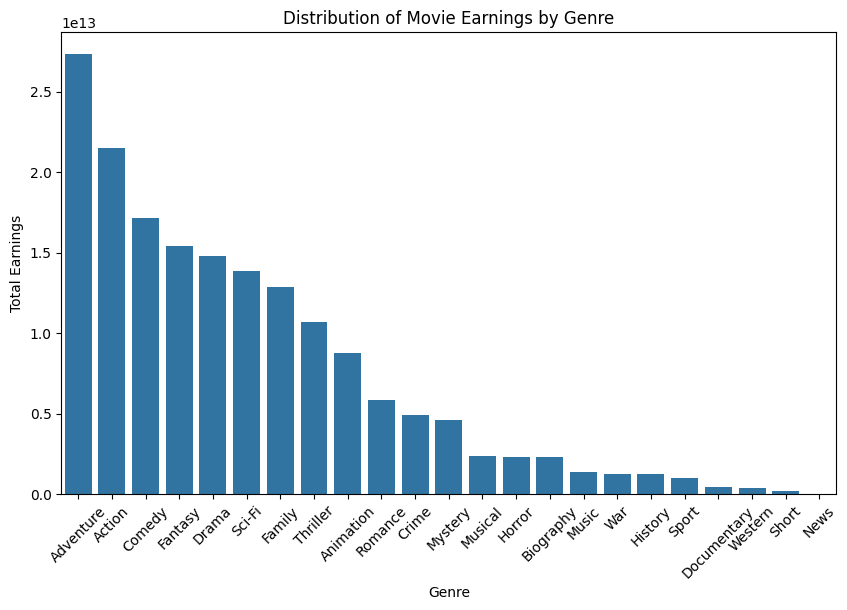

In [16]:
# 5. Distribution of how well each genre did (Domestic + International Earnings)
# Step 1: Flatten the 'Genres' column, so each genre gets its own row
genre_earnings = merged_df.explode('Genres')

# Step 2: Add the total earnings column (Domestic + International)
genre_earnings['Total_Earnings'] = genre_earnings['Domestic'] + genre_earnings['International']

# Step 3: Aggregate total earnings by genre (this will sum up earnings for movies that belong to multiple genres)
genre_earnings_sum = genre_earnings.groupby('Genres')['Total_Earnings'].sum().reset_index()

# Step 4: Sort the values for better visualization
genre_earnings_sum_sorted = genre_earnings_sum.sort_values('Total_Earnings', ascending=False)

# Step 5: Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Genres', y='Total_Earnings', data=genre_earnings_sum_sorted)
plt.xticks(rotation=45)
plt.title('Distribution of Movie Earnings by Genre')
plt.xlabel('Genre')
plt.ylabel('Total Earnings')
plt.show()


# Step 6: Correlation Analysis

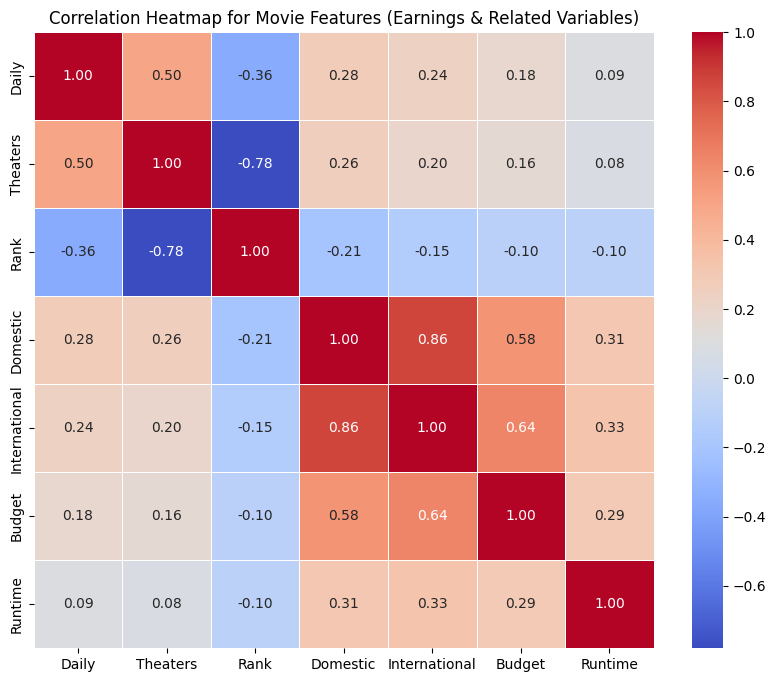

In [22]:
# Merge datasets on movie title
merged_df = daily_df.merge(attributes_df, left_on="Movie_Title", right_on="Title", how="left")
merged_df.drop(columns=["Title"], inplace=True)

# Handle missing data: Fill numerical columns with mean and categorical with the mode
numerical_cols = merged_df.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = merged_df.select_dtypes(include=["object"]).columns

# Impute missing values
imputer_num = SimpleImputer(strategy='mean')
merged_df[numerical_cols] = imputer_num.fit_transform(merged_df[numerical_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
merged_df[categorical_cols] = imputer_cat.fit_transform(merged_df[categorical_cols])

# Select only the numerical columns for correlation analysis
numeric_df = merged_df[numerical_cols]

# Compute the correlation matrix
corr = numeric_df.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Movie Features (Earnings & Related Variables)")
plt.show()
